# Project Luther

Kenny Leung - kenleung11@gmail.com

Part 5/8 - Combining and cleaning data obtained

This notebook documents the process of combining and cleaning the data scraped previously and obtaining a final dataset to be used in the regression model. 

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline

In [114]:
# read in all the csv files and create dataframes with pandas
college_df = pd.read_csv('college_data.csv',index_col=0)
draft_df = pd.read_csv('draft_data.csv',index_col=0)
player_df = pd.read_csv('player_raw.csv',index_col=0)
rookie_df = pd.read_csv('rookie_raw.csv', index_col=0)
rookie_advanced_df = pd.read_csv('rookie_advanced_raw.csv', index_col=0)

In [115]:
# filter out draft data before 2003 since college data is only available from 2003, remove other columns
draft_df = draft_df[draft_df['Draft_Yr'] > 2002]
draft_df = draft_df.loc[:,['Player','College','BPM']]

In [116]:
# merge dataframes on Player
result_df = player_df.merge(college_df, on='Player', how='left')
result_df = result_df.merge(draft_df, on='Player', how='left')
#result_df = result_df.merge(rookie_df, on='Player', how='left')
result = result_df.merge(rookie_advanced_df, on='Player', how='left')

In [117]:
# drafted players who did not play college
no_college = result[np.isnan(result['Yrs'])]
no_college.shape

(226, 55)

In [118]:
# drafted players who did not play in the NBA
no_nba = result[np.isnan(result['G'])]
no_nba.shape

(96, 55)

In [119]:
result = result[np.isfinite(result['Yrs'])]
result = result[np.isfinite(result['G'])]
result = result[np.isfinite(result['BPM_x'])]
result = result[np.isfinite(result['BPM_y'])]

In [120]:
result.shape

(544, 55)

In [121]:
print('Rookie Year BPM mean: ',result['BPM_y'].mean())
print('Rookie Year BPM std: ',result['BPM_y'].std())
print('Rookie Year BPM max: ',result.loc[result['BPM_y'].idxmax(axis=1)]['Player'],result['BPM_y'].max())
print('Rookie Year BPM min: ',result.loc[result['BPM_y'].idxmin(axis=1)]['Player'],result['BPM_y'].min())

Rookie Year BPM mean:  -3.4297794117647062
Rookie Year BPM std:  3.7876453162209676
Rookie Year BPM max:  Demetrius Jackson 6.3
Rookie Year BPM min:  Ben Bentil -26.9


In [122]:
print('Career Average BPM mean: ',draft_df['BPM'].mean())
print('Career Average BPM std: ',draft_df['BPM'].std())
print('Career Average BPM max: ',draft_df.loc[draft_df['BPM'].idxmax(axis=1)]['Player'],draft_df['BPM'].max())
print('Career Average BPM min: ',draft_df.loc[draft_df['BPM'].idxmin(axis=1)]['Player'],draft_df['BPM'].min())

Career Average BPM mean:  -2.5231098430813095
Career Average BPM std:  4.34622753012674
Career Average BPM max:  LeBron James 9.1
Career Average BPM min:  Mile Ilic -53.6


(-20, 10)

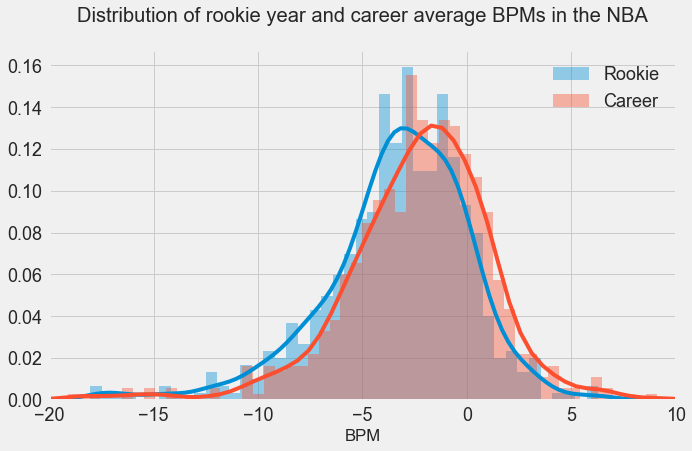

In [133]:
style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(10,6))
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)

sns.distplot(result['BPM_y'], ax=ax, bins=60)
sns.distplot(draft_df['BPM'], ax=ax, bins=120)
plt.title('Distribution of rookie year and career average BPMs in the NBA\n')
plt.xlabel('BPM')
plt.legend(['Rookie','Career'],fontsize=18)
ax.set_xlim(-20, 10)

# Creating dummy variables for the College column

There are certain colleges in NCAA basketball that produce a larger majority of good NBA players. Here, I grouped the drafted players by their college teams and looked at the top 10 colleges that contributed to the highest rookie year BPM. However, I only looked at colleges that produced more than 5 drafted NBA players in my timeframe. I then created a new college column, and changed the college value to "Bad" if the player did not attend one of the top 10 colleges. I then used this column to get dummy variables using pandas get_dummies.

In [51]:
# sort by box plus/minus (BPM)
sorted_BPM = result.sort_values(['BPM_y'], ascending=False)
sorted_BPM.columns

Index(['Player', 'Birthday', 'Height_ft', 'Height_in', 'Weight', 'Yrs', 'GP',
       'MPG', 'FGM', 'FGA', 'FG_Perc', '3PM', '3PA', '3P_Perc', 'FTM', 'FTA',
       'FT_Perc', 'TOV', 'PF', 'ORB', 'DRB', 'RPG', 'APG', 'SPG', 'BPG', 'PPG',
       'College', 'BPM_x', 'Season', 'Age', 'Tm', 'Lg', 'Pos', 'G', 'MP',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM_y', 'VORP'],
      dtype='object')

In [52]:
# check number of unique colleges
sorted_BPM['College'].nunique()

128

In [53]:
# average rookie year BPM grouped by College
sorted_BPM.groupby(['College']).mean()['BPM_y'].sort_values(ascending=False).head(20)

College
Morehead State University                     3.400000
Louisiana Tech University                     2.900000
0                                             2.500000
University of South Carolina                  1.400000
University of North Texas                     1.300000
Davidson College                              1.000000
Western Kentucky University                   0.850000
University of Tulsa                           0.600000
University of Utah                            0.133333
Weber State University                       -0.250000
Wake Forest University                       -0.400000
Saint Joseph's University                    -0.550000
San Diego State University                   -0.550000
University of Illinois at Urbana-Champaign   -0.750000
Norfolk State University                     -0.900000
Bowling Green State University               -0.900000
Villanova University                         -0.950000
St. John's University                        -1.000000
Ne

In [54]:
# create a dictionary with college and the count of how many NBA drafts they produced
college_count = dict(sorted_BPM.groupby(['College']).count()['BPM_y'])

In [55]:
def CollegeCountAbove5(college):
    '''
    Function to be used to create new column to filter out colleges that did not produce more than 5
    drafted players in the NBA
    '''
    if college_count[college] > 5:
        return 'Y'
    else:
        return 'N'

In [56]:
# create a new column to see whether that player went to a college that produced more than 5 NBA drafts
result['College_above_5'] = result['College'].apply(CollegeCountAbove5)

In [57]:
# top colleges and their average rookie BPMs
result[result['College_above_5'] == 'Y'].groupby(['College']).mean()['BPM_y'].sort_values(ascending=False).head(20)

College
University of Illinois at Urbana-Champaign   -0.750000
University of Florida                        -1.792308
University of Pittsburgh                     -1.933333
Stanford University                          -2.142857
Georgia Institute of Technology              -2.228571
University of Kansas                         -2.447368
Indiana University                           -2.533333
University of Washington                     -2.541667
University of Memphis                        -2.577778
University of North Carolina                 -2.583333
Oklahoma State University                    -2.583333
Louisiana State University                   -2.600000
Georgetown University                        -2.600000
University of Kentucky                       -2.653571
Duke University                              -2.710000
University of California, Los Angeles        -2.789474
University of Southern California            -2.800000
Ohio State University                        -3.025000
Un

In [58]:
# find top colleges based on drafted players BPM
top_colleges = list(result[result['College_above_5'] == 'Y'].groupby(['College']).mean()['BPM_y'].sort_values(ascending=False).head(10).index)

In [59]:
top_colleges

['University of Illinois at Urbana-Champaign',
 'University of Florida',
 'University of Pittsburgh',
 'Stanford University',
 'Georgia Institute of Technology',
 'University of Kansas',
 'Indiana University',
 'University of Washington',
 'University of Memphis',
 'University of North Carolina']

In [60]:
def TopCollege(x):
    '''
    Function to categorize all colleges outside of the top 10 colleges as "bad"
    '''
    if x in top_colleges:
        return x
    else:
        return 'Bad'

In [61]:
# create new column, shows college if it is in top college, bad otherwise
result['College_adj'] = result['College'].apply(TopCollege)

In [62]:
# create new dataframe of dummy variables, 1 if attended top college, 0 otherwise
dummies = pd.get_dummies(result['College_adj'])

In [63]:
# glue dummy and result dataframe
result = pd.concat([result, dummies], axis=1)

In [64]:
# renaming column headers to something easier to read
new_columns = ['Player',
 'Birthday',
 'Height_ft',
 'Height_in',
 'Weight',
 'Yrs_Played_College',
 'GP_College',
 'MPG_College',
 'FGM_College',
 'FGA_College',
 'FG_Perc_College',
 '3PM_College',
 '3PA_College',
 '3P_Perc_College',
 'FTM_College',
 'FTA_College',
 'FT_Perc_College',
 'TOV_College',
 'PF_College',
 'ORB_College',
 'DRB_College',
 'RPG_College',
 'APG_College',
 'SPG_College',
 'BPG_College',
 'PPG_College',
 'College',
 'Total_BPM_NBA',
 'Rookie_Season',
 'Rookie_Age',
 'Draft_Tm',
 'League',
 'Position',
 'GP_Rookie',
 'MP_Total_Rookie',
 'PER',
 'TS%',
 '3PAr',
 'FTr',
 'ORB%',
 'DRB%',
 'TRB%',
 'AST%',
 'STL%',
 'BLK%',
 'TOV%',
 'USG%',
 'OWS',
 'DWS',
 'WS_Rookie',
 'WS_per_48_Rookie',
 'OBPM',
 'DBPM',
 'BPM_Rookie',
 'VORP_Rookie',
 'College_above_5',
 'College_adj',
 'Bad'] + top_colleges

In [65]:
result.columns = new_columns

In [66]:
# create new column for total height in inches
result['Total_Height_in'] = result['Height_ft'] * 12 + result['Height_in']

In [67]:
# a college player typically plays for a max 4 years in college, the datafram shows a few players who played
# more than 4 years. This is because the college stats dataframe was grouped by name and averaged and these players
# share the same name
result[result['Yrs_Played_College'] > 4]

,Player,Birthday,Height_ft,Height_in,Weight,Yrs_Played_College,GP_College,MPG_College,FGM_College,FGA_College,...,University of Florida,University of Pittsburgh,Stanford University,Georgia Institute of Technology,University of Kansas,Indiana University,University of Washington,University of Memphis,University of North Carolina,Total_Height_in
133,David Lee,1983-04-29,6,9,245,5.0,30.000000,28.980000,4.640000,9.280000,...,0,0,1,0,0,0,0,0,0,81
196,James White,1982-10-21,6,7,200,5.0,30.400000,25.820000,3.780000,7.680000,...,0,0,0,0,0,0,0,0,0,79
199,Paul Davis,1984-07-21,6,11,270,7.0,30.857143,25.142857,4.071429,7.585714,...,0,0,0,0,0,0,0,0,0,83
210,Dee Brown,1984-08-17,6,0,185,7.0,33.000000,32.185714,4.285714,10.100000,...,0,0,0,1,0,0,0,0,0,72
292,Jason Thompson,1986-07-21,6,11,250,5.0,29.800000,29.280000,5.540000,10.740000,...,0,0,0,0,0,0,0,0,0,83
301,Ryan Anderson,1988-05-06,6,10,240,10.0,31.600000,29.490000,4.530000,9.570000,...,0,0,0,0,0,0,0,0,0,82
346,Terrence Williams,1987-06-28,6,6,220,7.0,33.714286,29.642857,3.685714,9.414286,...,0,0,0,0,0,0,0,0,0,78
351,James Johnson,1987-02-20,6,9,250,7.0,31.428571,30.357143,4.614286,10.642857,...,0,0,0,0,0,0,0,0,0,81
378,Marcus Thornton,1987-06-05,6,4,205,8.0,32.250000,32.137500,5.450000,12.325000,...,0,0,0,0,0,0,0,0,0,76
447,Derrick Williams,1991-05-25,6,8,240,5.0,31.000000,29.220000,4.300000,8.560000,...,0,0,0,0,0,0,0,0,0,80


In [68]:
# define a function max4 that changes the years in college to max 4
def max4(yrs):
    '''
    Function that limits the maximum years played in college to 4
    '''
    if yrs > 4:
        return 4
    else:
        return yrs

In [69]:
# apply max4 function
result['Yrs_Played_College'] = result['Yrs_Played_College'].apply(max4)

In [70]:
# create new column for rookie draft year
result['Draft_Yr'] = result['Rookie_Season'].apply(lambda x:x[:4])

In [71]:
# create a column of draft year and draft team to be used as a key to merge team BPM csv file
result['Yr_Tm'] = result["Draft_Yr"].map(str) + result["Draft_Tm"]

In [72]:
# read team BPM file
BPMs = pd.read_csv('team_bpm.csv',index_col=0)

In [73]:
# merge dataframes
result = pd.merge(result,BPMs,on=['Yr_Tm'],how='right')

In [74]:
result.columns

Index(['Player', 'Birthday', 'Height_ft', 'Height_in', 'Weight',
       'Yrs_Played_College', 'GP_College', 'MPG_College', 'FGM_College',
       'FGA_College', 'FG_Perc_College', '3PM_College', '3PA_College',
       '3P_Perc_College', 'FTM_College', 'FTA_College', 'FT_Perc_College',
       'TOV_College', 'PF_College', 'ORB_College', 'DRB_College',
       'RPG_College', 'APG_College', 'SPG_College', 'BPG_College',
       'PPG_College', 'College', 'Total_BPM_NBA', 'Rookie_Season',
       'Rookie_Age', 'Draft_Tm_x', 'League', 'Position', 'GP_Rookie',
       'MP_Total_Rookie', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS_Rookie',
       'WS_per_48_Rookie', 'OBPM', 'DBPM', 'BPM_Rookie', 'VORP_Rookie',
       'College_above_5', 'College_adj', 'Bad',
       'University of Illinois at Urbana-Champaign', 'University of Florida',
       'University of Pittsburgh', 'Stanford University',
       'Georgia Institute of Technolo

In [75]:
# remove columns to create a final dataframe
result = result[['Player', 'Birthday', 'Total_Height_in', 'Weight',
       'Yrs_Played_College', 'GP_College', 'MPG_College', 'FGM_College',
       'FGA_College', 'FG_Perc_College', '3PM_College', '3PA_College',
       '3P_Perc_College', 'FTM_College', 'FTA_College', 'FT_Perc_College',
       'TOV_College', 'PF_College', 'ORB_College', 'DRB_College',
       'RPG_College', 'APG_College', 'SPG_College', 'BPG_College',
       'PPG_College', 'College', 'Total_BPM_NBA',
       'Rookie_Age', 'Position', 'GP_Rookie',
       'MP_Total_Rookie', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS_Rookie',
       'WS_per_48_Rookie', 'OBPM', 'DBPM', 'BPM_Rookie', 'VORP_Rookie',
       'College_above_5', 'College_adj', 'Bad',
       'Georgia Institute of Technology', 'Indiana University',
       'Stanford University', 'University of Florida',
       'University of Illinois at Urbana-Champaign', 'University of Kansas',
       'University of Memphis', 'University of North Carolina',
       'University of Pittsburgh', 'University of Washington',
       'Yr_Tm','BPM_top3', 'BPM_top5', 'BPM_top7', 'BPM_top13',
       'top3/top5', 'top3/top7', 'top3/top13', 'top5/top13', 'top7/top13']]

In [76]:
result = result[np.isfinite(result['Weight'])]

In [77]:
print('I scraped',college_df.shape[0],'college player stats.')
print('There have been',player_df.shape[0], 'players drafted into the NBA since 2003.')
print('Of those',player_df.shape[0], 'drafted players,',no_nba.shape[0],'did not play in the NBA.')
print('Of the',player_df.shape[0], 'drafted players,',no_college.shape[0],'did not play in the NCAA.')
print('Filtering out these players, the resulting data set has',result.shape[0],'players, and',result.shape[1],'features.')

I scraped 13162 college player stats.
There have been 798 players drafted into the NBA since 2003.
Of those 798 drafted players, 96 did not play in the NBA.
Of the 798 drafted players, 226 did not play in the NCAA.
Filtering out these players, the resulting data set has 509 players, and 74 features.


In [78]:
# save result dataframe as csv
result.to_csv('result_data.csv')

In [107]:
result[result['BPM_Rookie'] == result['BPM_Rookie'].max()][['Player','BPM_Rookie']]

,Player,BPM_Rookie
481,Demetrius Jackson,6.3


In [109]:
result[result['BPM_Rookie'] > 4].sort_values(['BPM_Rookie'], ascending=False)[['Player','BPM_Rookie']]

,Player,BPM_Rookie
481,Demetrius Jackson,6.3
58,Chris Paul,6.1
104,James Augustine,5.0
170,Kawhi Leonard,4.3


In [110]:
result.shape

(509, 74)